# Importing Necesseties 

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
# import spacy
import random
# from spacy.util import compounding
# from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# Reading the Data

In [3]:
train = pd.read_csv('VADER-TWT-23K.csv')

In [4]:
print(train.shape)


(13023, 6)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13023 entries, 0 to 13022
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   13023 non-null  int64  
 1   Date         13023 non-null  object 
 2   Tweet        12875 non-null  object 
 3   clean_tweet  12140 non-null  object 
 4   Score        13023 non-null  float64
 5   Sentiment    13023 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 610.6+ KB


In [6]:
train.dropna(inplace=True)

# EDA

In [7]:
train.head()

Unnamed: 0        Date                                              Tweet  \
0           0  2020-01-01  3us  Happy New Year!, thank you for your great...   
1           1  2020-01-01  777 You are very right. The activist investors...   
2           2  2020-01-01      Our next decade will be bigger than the last.   
3           3  2020-01-01                 Looks like a financial advice ð¤   
4           4  2020-01-02  Bitcoin social volume has reached the highest ...   

                                         clean_tweet   Score Sentiment  
0              happi year thank your great intellect  0.8625  positive  
1  veri right activist investor hodler last resor... -0.0772  negative  
2                   next decad will bigger than last  0.0000   neutral  
3                            look like financi advic  0.3612  positive  
4  bitcoin social volum reach highest level sinc ...  0.3182  positive

In [8]:
temp = train.groupby('Sentiment').count()['Tweet'].reset_index().sort_values(by='Tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

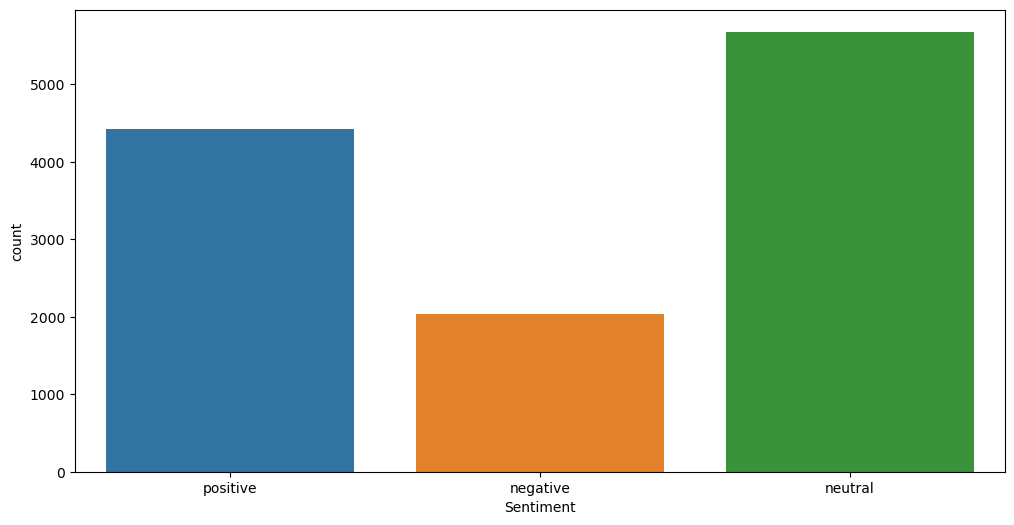

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=train)

In [10]:
temp.to_csv('BAR-PLOT-TWT-COUNT.csv')

In [11]:
# fig = go.Figure(go.Funnelarea(
#     text =temp.Sentiment,
#     values = temp.Tweet,
#     title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
#     ))
# fig.show()
fig = px.bar(temp, x="Sentiment", y="Tweet",color="Sentiment", title="Long-Form Input")
fig.show()

In [12]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [13]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.Tweet
    sentence2 = row.clean_tweet

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [14]:
jaccard = pd.DataFrame(results_jaccard,columns=["Tweet","clean_tweet","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [15]:
train['Num_words_ST'] = train['clean_tweet'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['Tweet'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [16]:
train.head()

Unnamed: 0        Date                                              Tweet  \
0           0  2020-01-01  3us  Happy New Year!, thank you for your great...   
1           1  2020-01-01  777 You are very right. The activist investors...   
2           2  2020-01-01      Our next decade will be bigger than the last.   
3           3  2020-01-01                 Looks like a financial advice ð¤   
4           4  2020-01-02  Bitcoin social volume has reached the highest ...   

                                         clean_tweet   Score Sentiment  \
0              happi year thank your great intellect  0.8625  positive   
1  veri right activist investor hodler last resor... -0.0772  negative   
2                   next decad will bigger than last  0.0000   neutral   
3                            look like financi advic  0.3612  positive   
4  bitcoin social volum reach highest level sinc ...  0.3182  positive   

   jaccard_score  Num_words_ST  Num_word_text  difference_in_words  
0       0.230769             6             10                    4  
1       0.239130            26             38                   12  
2       0.363636             6              9                    3  
3       0.111111             4              6                    2  
4       0.235294            28             38                   10

In [17]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['clean_tweet', 'Tweet']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

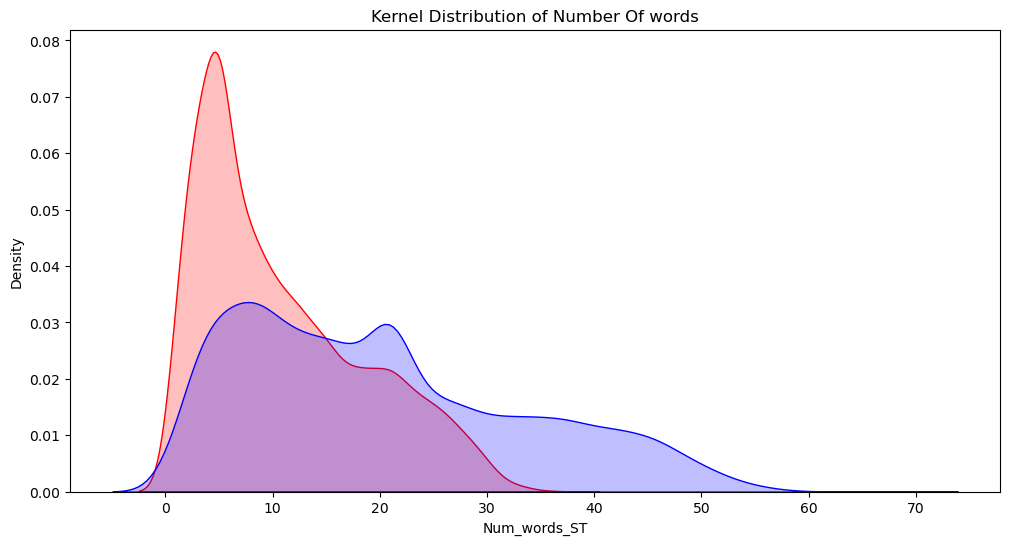

In [18]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

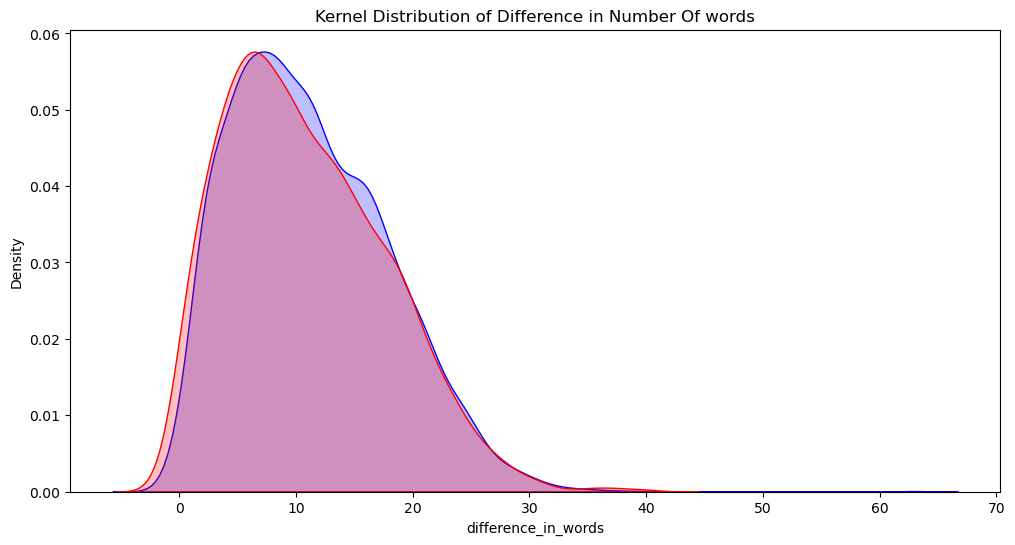

In [19]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['Sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['Sentiment']=='negative']['difference_in_words'], shade=True, color="r")

<AxesSubplot:xlabel='difference_in_words'>

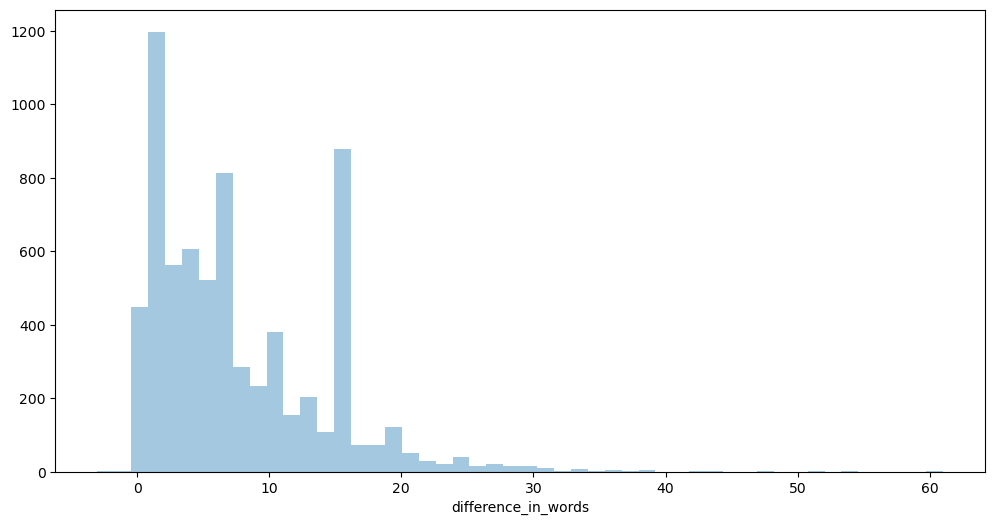

In [20]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['Sentiment']=='neutral']['difference_in_words'],kde=False)

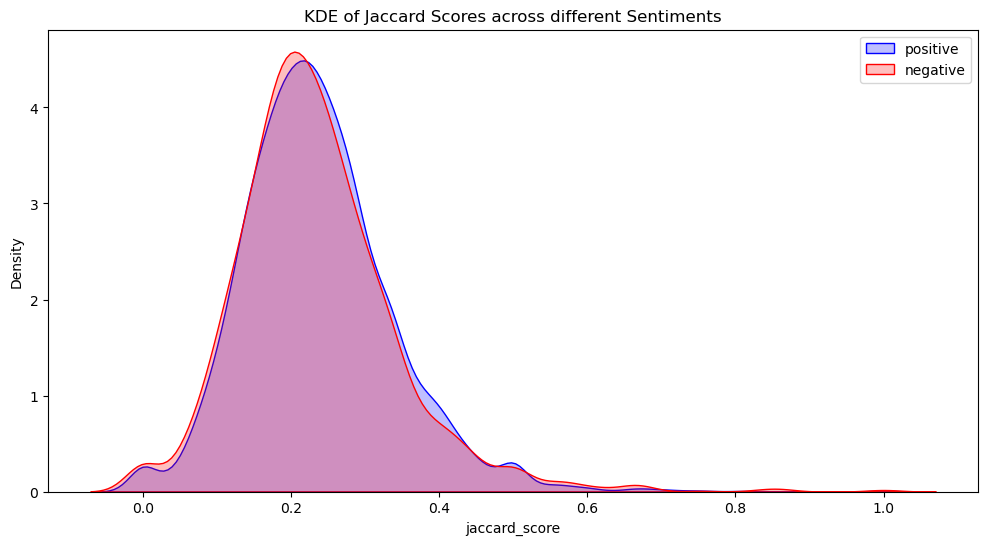

In [21]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['Sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['Sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

<AxesSubplot:xlabel='jaccard_score'>

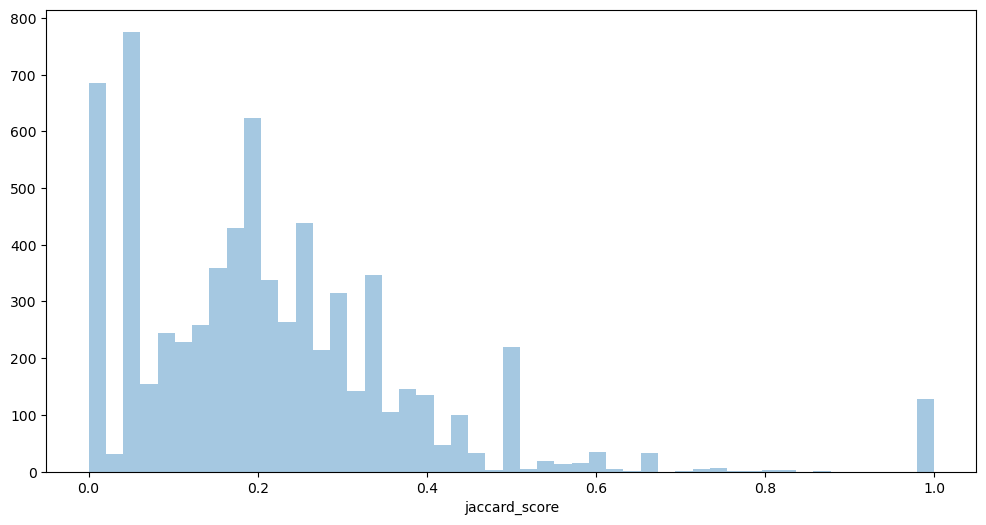

In [22]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['Sentiment']=='neutral']['jaccard_score'],kde=False)

In [23]:
k = train[train['Num_word_text']<=2]

In [24]:
k.groupby('Sentiment').mean()['jaccard_score']

Sentiment
negative    0.285714
neutral     0.433620
positive    0.194444
Name: jaccard_score, dtype: float64

In [25]:
k[k['Sentiment']=='positive']

Unnamed: 0        Date                                      Tweet  \
70            77  2020-01-11                  _Livin_Truth    _Bitcoin    
176          179  2020-01-21                                    Thanks    
1281        1276  2020-05-11                             Thanks Satoshi   
1365        1370  2020-05-16                           Best explanation   
2716        2713  2021-02-18                                    GREAT!!   
2834        2850  2021-03-13                                     GREAT!   
2835        2850  2021-03-13                                     GREAT!   
2836        3134  2021-04-26                                     GREAT!   
2837        3134  2021-04-26                                     GREAT!   
2940        2957  2021-03-27                                 Good weed.   
4451        3786  2021-07-17                                   Freedom.   
4919        4413  2021-10-06                       Perfect perfomance)    
5101        4619  2021-10-19       Respect ðâ¤ï¸âð¥â³ððª   
5308        4829  2021-11-02                                  Love this   
5522        5043  2021-11-19                                     Thanks   
6798        6501  2022-05-24                                 Nice chart   
7748        7517  2022-10-26                              Well played,    
8029        7824  2022-12-13                                      Good.   

              clean_tweet   Score Sentiment  jaccard_score  Num_words_ST  \
70    livin truth bitcoin  0.3182  positive       0.000000             3   
176                 thank  0.3612  positive       0.000000             1   
1281        thank satoshi  0.3612  positive       0.333333             2   
1365          best explan  0.6369  positive       0.333333             2   
2716                great  0.6249  positive       0.000000             1   
2834                great  0.6249  positive       0.000000             1   
2835                great  0.6249  positive       0.000000             1   
2836                great  0.6249  positive       0.000000             1   
2837                great  0.6249  positive       0.000000             1   
2940            good weed  0.4404  positive       0.333333             2   
4451              freedom  0.6369  positive       0.000000             1   
4919       perfect perfom  0.5719  positive       0.333333             2   
5101              respect  0.4767  positive       0.500000             1   
5308             love thi  0.6369  positive       0.333333             2   
5522                thank  0.3612  positive       0.000000             1   
6798           nice chart  0.4215  positive       1.000000             2   
7748            well play  0.5423  positive       0.333333             2   
8029                 good  0.4404  positive       0.000000             1   

      Num_word_text  difference_in_words  
70                2                   -1  
176               1                    0  
1281              2                    0  
1365              2                    0  
2716              1                    0  
2834              1                    0  
2835              1                    0  
2836              1                    0  
2837              1                    0  
2940              2                    0  
4451              1                    0  
4919              2                    0  
5101              2                    1  
5308              2                    0  
5522              1                    0  
6798              2                    0  
7748              2                    0  
8029              1                    0

In [26]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [27]:
train['Tweet'] = train['Tweet'].apply(lambda x:clean_text(x))
train['clean_tweet'] = train['clean_tweet'].apply(lambda x:clean_text(x))

In [28]:
train.head()

Unnamed: 0        Date                                              Tweet  \
0           0  2020-01-01    happy new year thank you for your great inte...   
1           1  2020-01-01   you are very right the activist investors hod...   
2           2  2020-01-01       our next decade will be bigger than the last   
3           3  2020-01-01                 looks like a financial advice ð¤   
4           4  2020-01-02  bitcoin social volume has reached the highest ...   

                                         clean_tweet   Score Sentiment  \
0              happi year thank your great intellect  0.8625  positive   
1  veri right activist investor hodler last resor... -0.0772  negative   
2                   next decad will bigger than last  0.0000   neutral   
3                            look like financi advic  0.3612  positive   
4  bitcoin social volum reach highest level sinc ...  0.3182  positive   

   jaccard_score  Num_words_ST  Num_word_text  difference_in_words  
0       0.230769             6             10                    4  
1       0.239130            26             38                   12  
2       0.363636             6              9                    3  
3       0.111111             4              6                    2  
4       0.235294            28             38                   10

In [29]:
train['temp_list'] = train['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [30]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [31]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [32]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

In [33]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [34]:
train['temp_list1'] = train['Tweet'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [39]:
Positive_sent = train[train['Sentiment']=='positive']
Negative_sent = train[train['Sentiment']=='negative']
Neutral_sent = train[train['Sentiment']=='neutral']

In [40]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

In [41]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [42]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

In [43]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [44]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

In [45]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [46]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

In [47]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [48]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.Sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.Sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

### Positive Tweets

In [49]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


In [50]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

In [51]:
Unique_Positive.columns

Index(['words', 'count'], dtype='object')

In [52]:
Unique_Positive=Unique_Positive.drop([4,6,9])

In [55]:
Unique_Positive.to_csv('POSITIVE-TWT.csv')

In [56]:
import plotly.express as px

fig = px.pie(Unique_Positive, values='count', names='words'
             ,color_discrete_sequence=px.colors.diverging.Spectral)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# color_discrete_sequence= px.colors.sequential.Plasma_r)


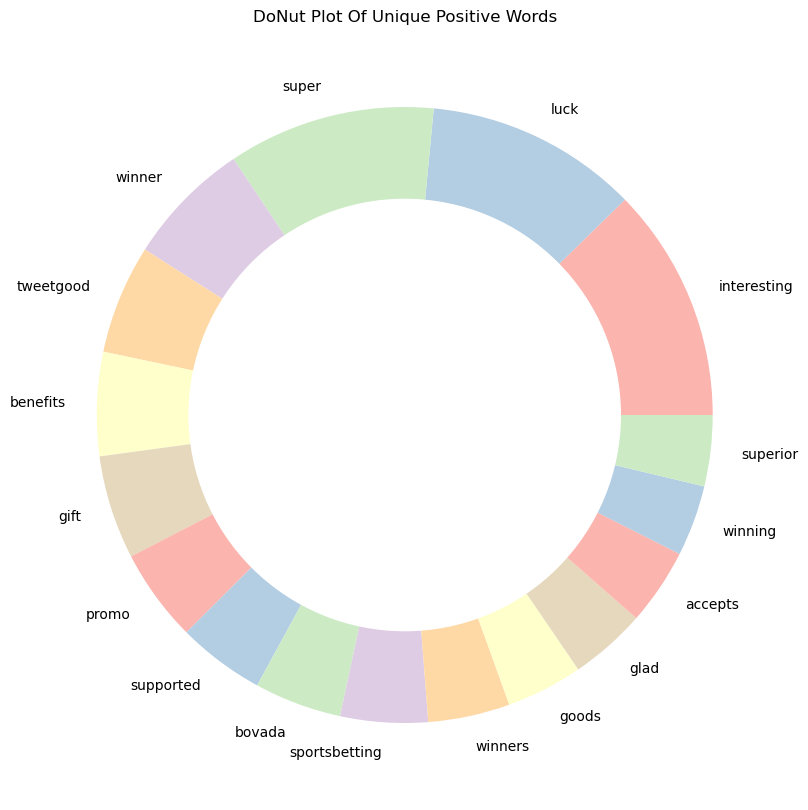

In [57]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [58]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


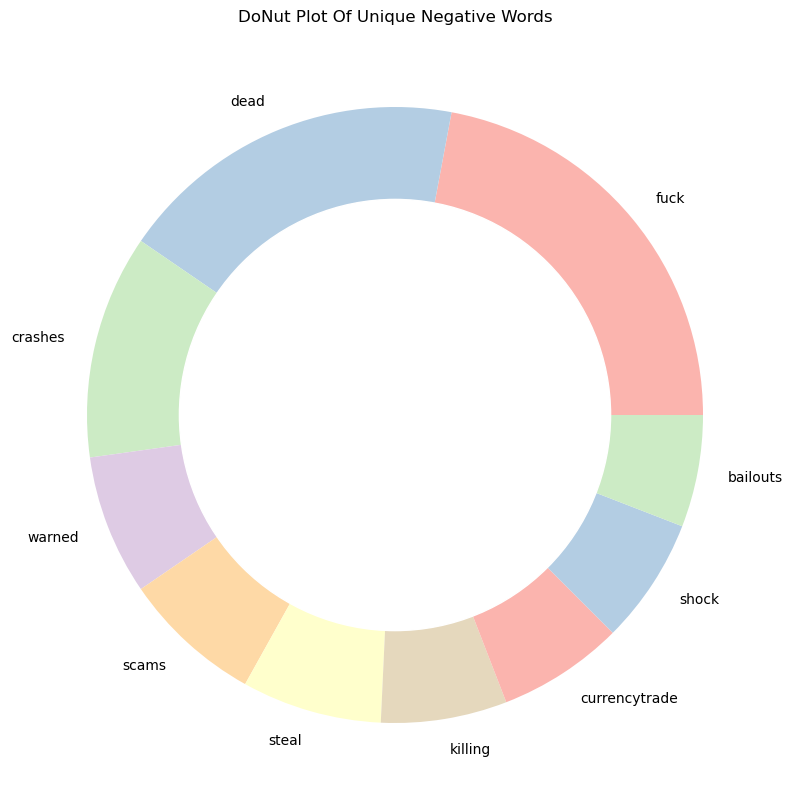

In [59]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [63]:
Unique_Negative.to_csv('NEGATIVE-TWT.csv')

In [64]:
fig = px.pie(Unique_Negative, values='count', names='words'
             ,color_discrete_sequence=px.colors.diverging.Spectral)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [65]:
def plot_wordcloud(text, mask=None, max_words=500, max_font_size=100, figure_size=(11,5), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=100, 
                    height=50,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  


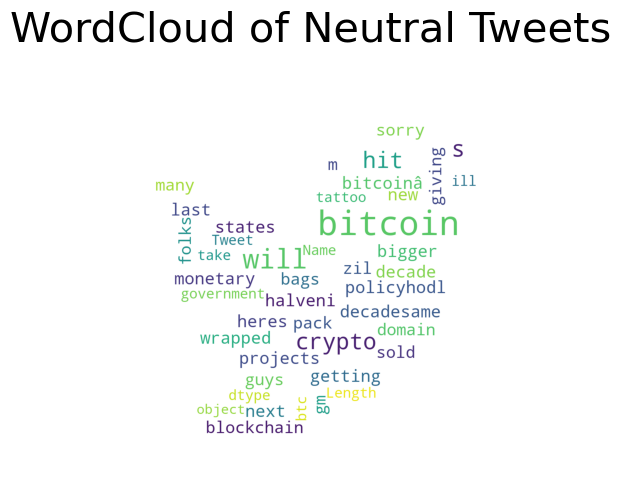

In [66]:
pos_mask = np.array(Image.open('bird.jpg'))
plot_wordcloud(Neutral_sent.Tweet,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

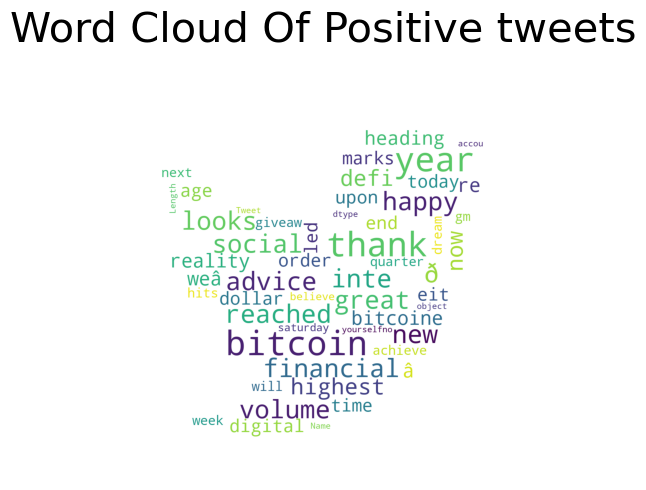

In [67]:
plot_wordcloud(Positive_sent.Tweet,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

In [68]:
train

Unnamed: 0        Date  \
0               0  2020-01-01   
1               1  2020-01-01   
2               2  2020-01-01   
3               3  2020-01-01   
4               4  2020-01-02   
...           ...         ...   
13513       13018  2023-04-01   
13514       13019  2023-04-01   
13515       13020  2023-04-01   
13516       13021  2023-04-01   
13517       13022  2023-04-01   

                                                   Tweet  \
0        happy new year thank you for your great inte...   
1       you are very right the activist investors hod...   
2           our next decade will be bigger than the last   
3                     looks like a financial advice ð¤   
4      bitcoin social volume has reached the highest ...   
...                                                  ...   
13513  if you can dream it you can achieve it if you ...   
13514  how many other bitcoin will the government be ...   
13515                          bitcoin will hit  before    
13516  gm ✅️ its saturday believe in yourselfno accou...   
13517             if bitcoin hits  ill take a btc tattoo   

                                             clean_tweet   Score Sentiment  \
0                  happi year thank your great intellect  0.8625  positive   
1      veri right activist investor hodler last resor... -0.0772  negative   
2                       next decad will bigger than last  0.0000   neutral   
3                                look like financi advic  0.3612  positive   
4      bitcoin social volum reach highest level sinc ...  0.3182  positive   
...                                                  ...     ...       ...   
13513                   dream achiev hodl bitcoin crypto  0.2500  positive   
13514  mani other bitcoin will govern sell asid from ...  0.0000   neutral   
13515                                 bitcoin will befor  0.0000   neutral   
13516  saturday believ yourself account should have l...  0.1027  positive   
13517                            bitcoin hit take tattoo  0.0000   neutral   

       jaccard_score  Num_words_ST  Num_word_text  difference_in_words  \
0           0.230769             6             10                    4   
1           0.239130            26             38                   12   
2           0.363636             6              9                    3   
3           0.111111             4              6                    2   
4           0.235294            28             38                   10   
...              ...           ...            ...                  ...   
13513       0.266667             5             22                   17   
13514       0.250000            28             38                   10   
13515       0.285714             3              6                    3   
13516       0.217391            21             39                   18   
13517       0.300000             4              9                    5   

                                               temp_list  \
0                 [happi, year, thank, great, intellect]   
1      [veri, right, activist, investor, hodler, last...   
2                            [next, decad, bigger, last]   
3                           [look, like, financi, advic]   
4      [bitcoin, social, volum, reach, highest, level...   
...                                                  ...   
13513             [dream, achiev, hodl, bitcoin, crypto]   
13514  [mani, bitcoin, govern, sell, asid, sell, silk...   
13515                                   [bitcoin, befor]   
13516  [saturday, believ, account, le, follow, follow...   
13517                       [bitcoin, hit, take, tattoo]   

                                              temp_list1  
0            [happy, new, year, thank, great, intellect]  
1      [right, activist, investors, hodlers, last, re...  
2                           [next, decade, bigger, last]  
3                 [looks, like, financial, advice, ð¤]  
4      [bitcoin, social, volume, reached, highe

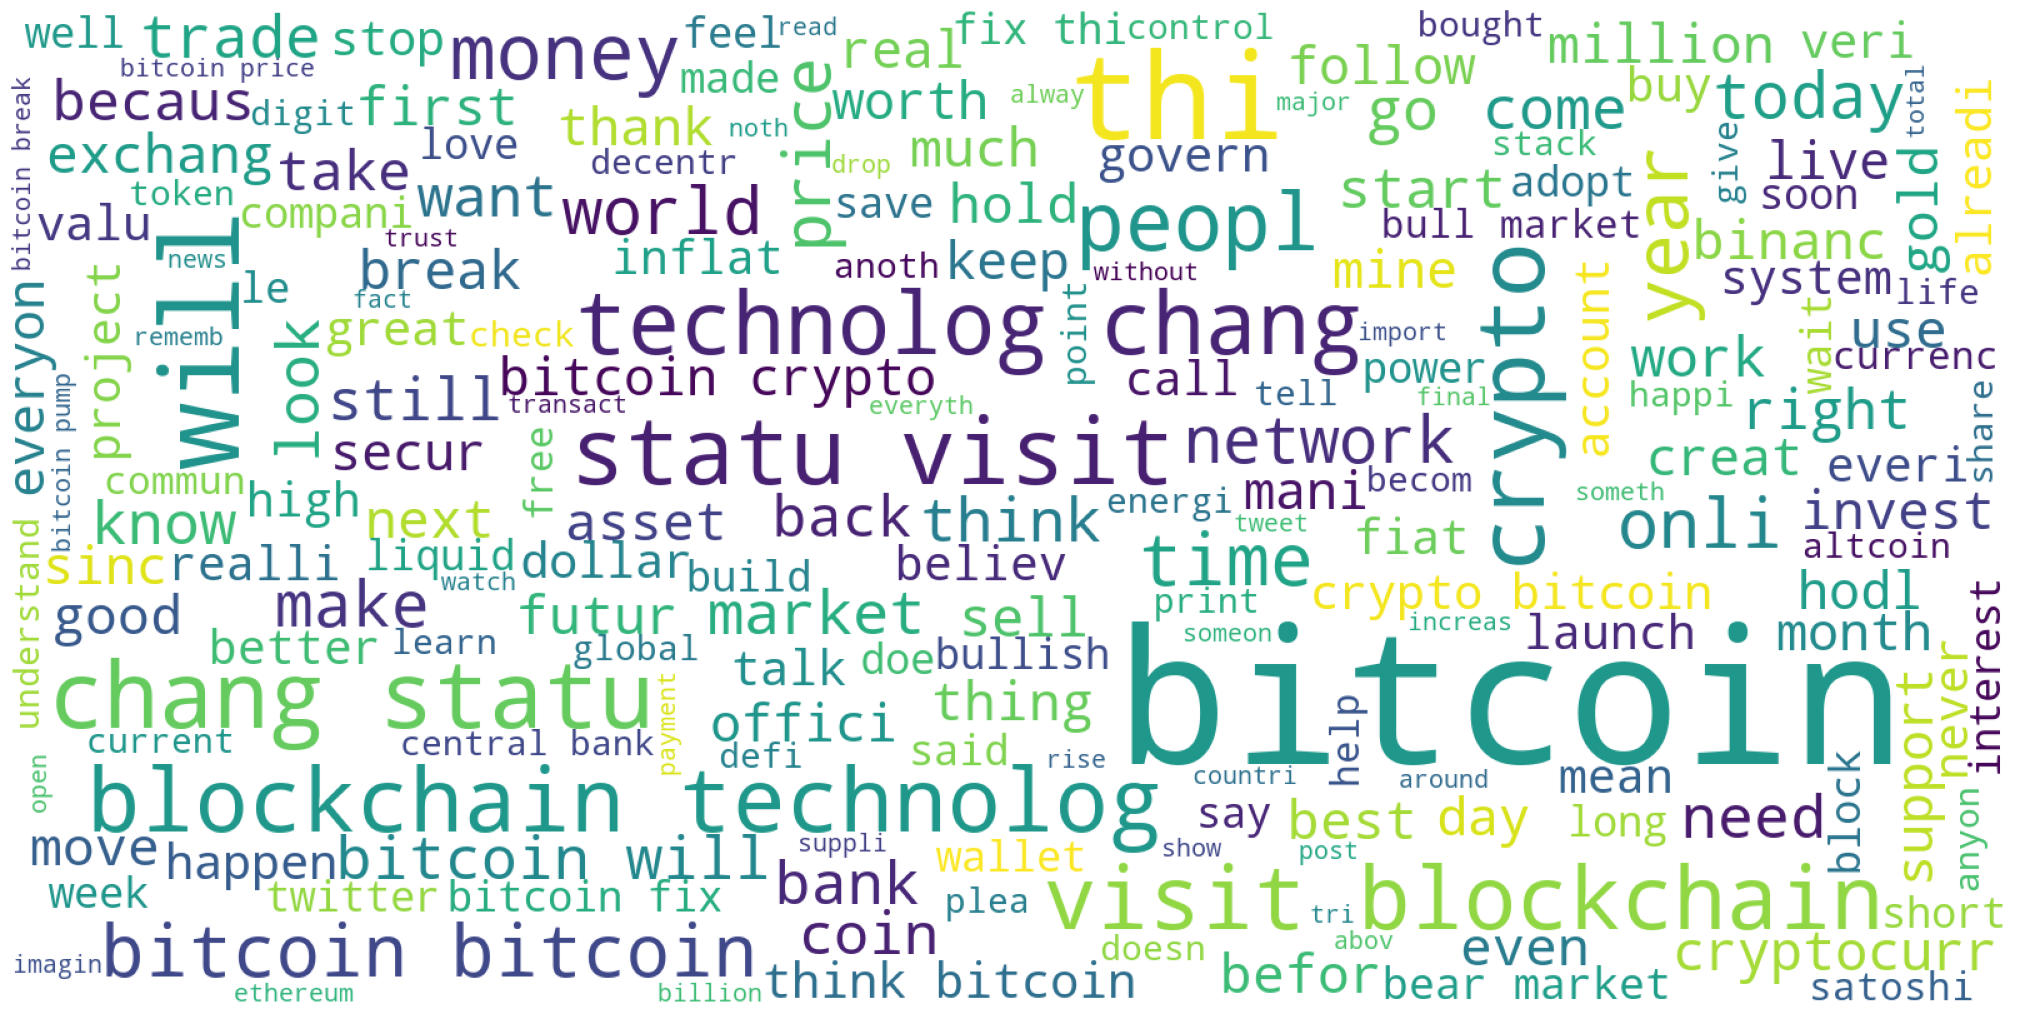

In [69]:
# word cloud visualization
def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([twts for twts in text])
    wordCloud = WordCloud(background_color='white',width = 1600, height = 800,
                          stopwords = stopwords,min_font_size = 20,
                          max_font_size=150,colormap='viridis').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()


word_cloud(train['clean_tweet'].values)